In [50]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime
import matplotlib.pyplot as plt
import glob as gb
import os
import matplotlib.dates as mdates
from cycler import cycler
from collections import OrderedDict

%matplotlib notebook

In [2]:
# Load HDF file
folder = 'T26_reflectance_standard'
df = pd.HDFStore('../Data/' + str(folder) +'/analysis.h5')['df']

# Create column for time since start of measurement
df['delta'] = (df['datetime']-df['datetime'][0]).fillna(0).astype('timedelta64[us]')/(1E6*60)

In [3]:
df.head()
# df.info()

,datetime,chip,concentration,current,fs,humidity,measurementID,medium,optical power,sample_no,sweep_no,sweeps,tempC,A,tau,c,delta
0,2016-08-04 14:45:42.744841,T27,0,0.5,0.0001,44.23,T26_reflectance_standard,Reflectance Standards,0.000155,1000,1,200,25.16,1.942201,10.021006,0.022686,0.000000
1,2016-08-04 14:45:43.096861,T27,0,0.5,0.0001,44.23,T26_reflectance_standard,Reflectance Standards,0.000155,1000,2,200,25.16,1.936101,10.030267,0.023589,0.005867
2,2016-08-04 14:45:43.441881,T27,0,0.5,0.0001,44.23,T26_reflectance_standard,Reflectance Standards,0.000155,1000,3,200,25.16,1.938928,10.008306,0.023905,0.011617
3,2016-08-04 14:45:43.636892,T27,0,0.5,0.0001,44.23,T26_reflectance_standard,Reflectance Standards,0.000155,1000,4,200,25.16,1.943988,10.044293,0.022999,0.014868
4,2016-08-04 14:45:43.841904,T27,0,0.5,0.0001,44.23,T26_reflectance_standard,Reflectance Standards,0.000155,1000,5,200,25.16,1.948916,10.023532,0.023961,0.018284


# Real time raw data

In [4]:
grouped = df.groupby(['concentration'])

<IPython.core.display.Javascript object>


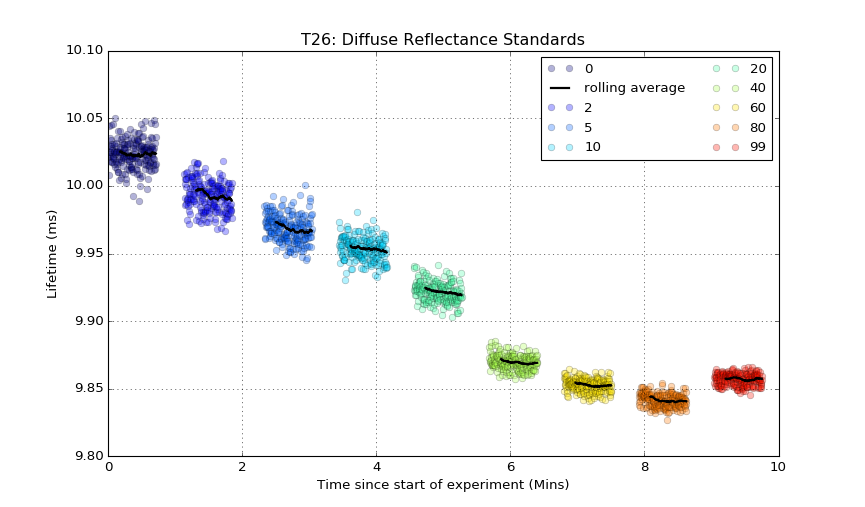

In [54]:
# Create colormap for plotting
n = len(df.concentration.unique()) # Number of colors
new_colors = [plt.get_cmap('jet')(1. * i/n) for i in range(n)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

# All in one
fig, ax = plt.subplots()

for key, group in grouped:
    ax.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50).mean()
#     ax.plot(group['delta'], rolling, '-', lw=2, label='rolling ({k})'.format(k=key), color='black')
    ax.plot(group['delta'], rolling, '-', lw=2, label='rolling average', color='black')

ax.xaxis.grid(True, which="major")
ax.yaxis.grid()
handles, labels = plt.gca().get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='best', ncol=2, fontsize='medium')
plt.xlabel('Time since start of experiment (Mins)')
plt.ylabel('Lifetime (ms)')
plt.title('T26: Diffuse Reflectance Standards')
plt.savefig('../Data/' + str(folder) + '/lifetimeVsTime.png', dpi=500)

# Each concentration vs lifetime (Rolling Mean)

In [35]:
plt.close("all")

<IPython.core.display.Javascript object>


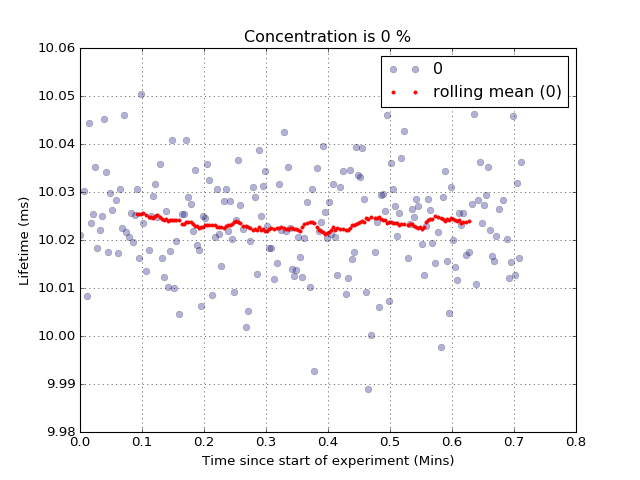

<IPython.core.display.Javascript object>


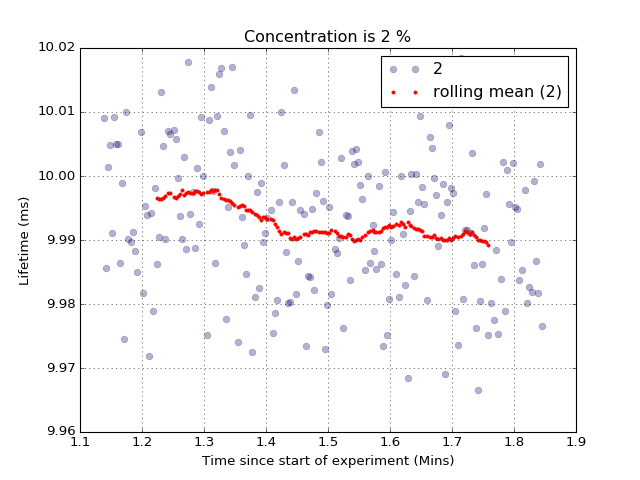

<IPython.core.display.Javascript object>


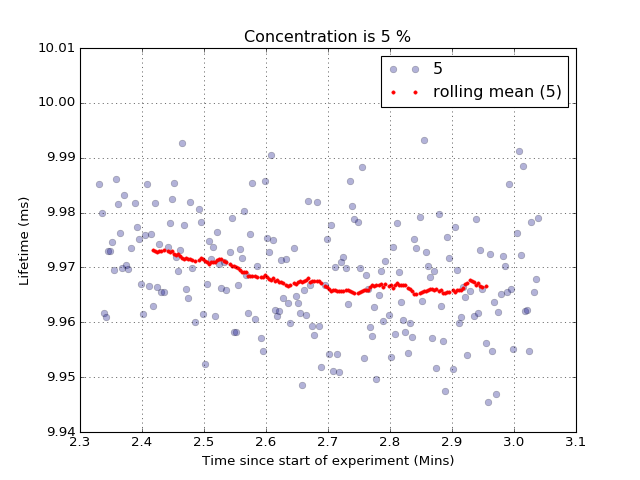

<IPython.core.display.Javascript object>


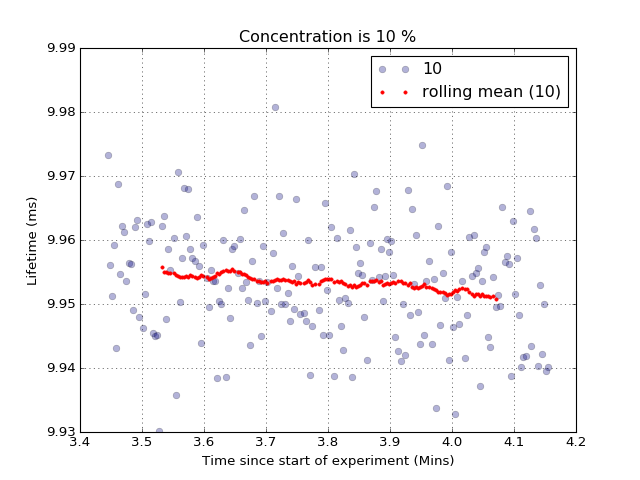

<IPython.core.display.Javascript object>


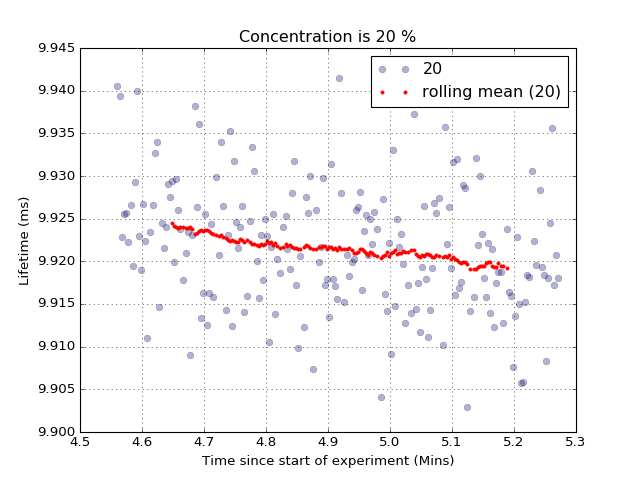

<IPython.core.display.Javascript object>


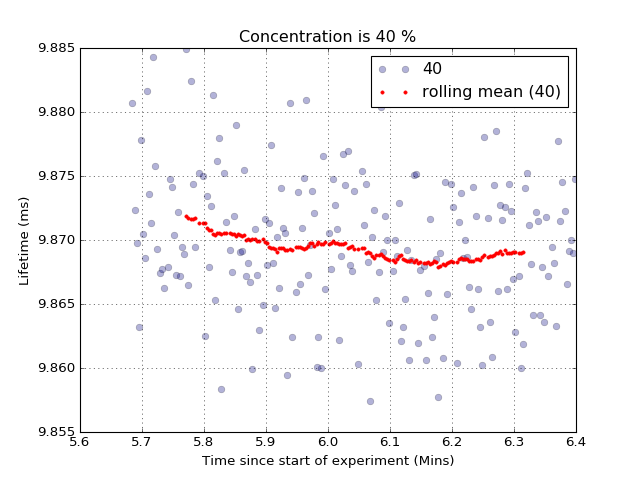

<IPython.core.display.Javascript object>


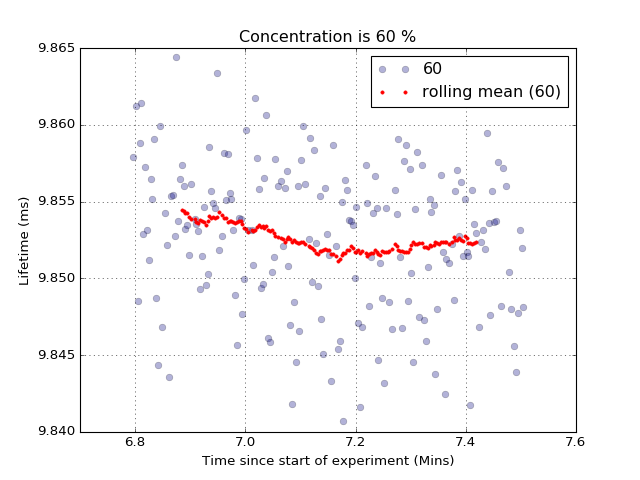

<IPython.core.display.Javascript object>


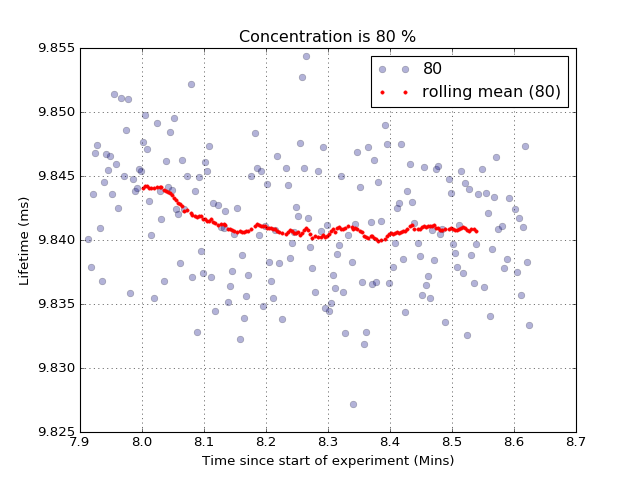

<IPython.core.display.Javascript object>


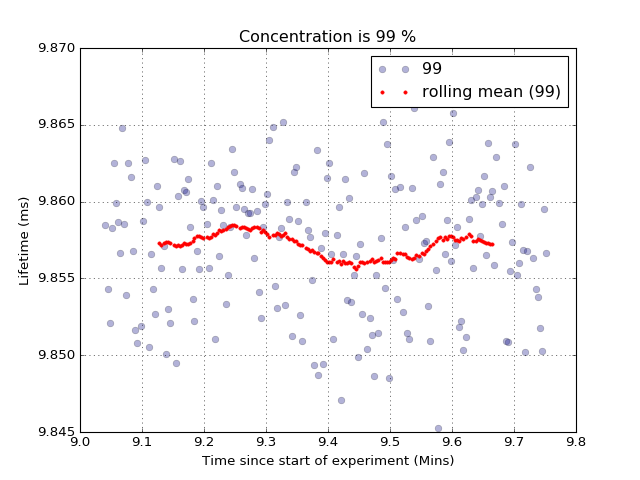

In [56]:
# Individual plots
try:
    os.mkdir('../Data/' + str(folder) + '/individual/')
except:pass
for key, group in grouped:
    plt.figure()
    plt.ticklabel_format(useOffset=False, axis='y')
    plt.plot(group['delta'], group['tau'], 'o', alpha=0.3, label=key)
    rolling = group['tau'].rolling(window=50, center=True).mean()
    plt.plot(group['delta'], rolling, '.', lw=3, color='red', label='rolling mean ({k})'.format(k=key)) 
    plt.title('Concentration is {} %'.format(key))
    plt.grid()
    plt.xlabel('Time since start of experiment (Mins)')
    plt.ylabel('Lifetime (ms)')
    plt.legend()
    plt.savefig('../Data/' + str(folder) + '/individual/' + str(key) + '.png', dpi=200)

In [57]:
plt.close("all")

## tau & A vs concentration

In [39]:
# Apply mean and std functions to all collumns
g = grouped.agg([np.mean, np.std])

<IPython.core.display.Javascript object>


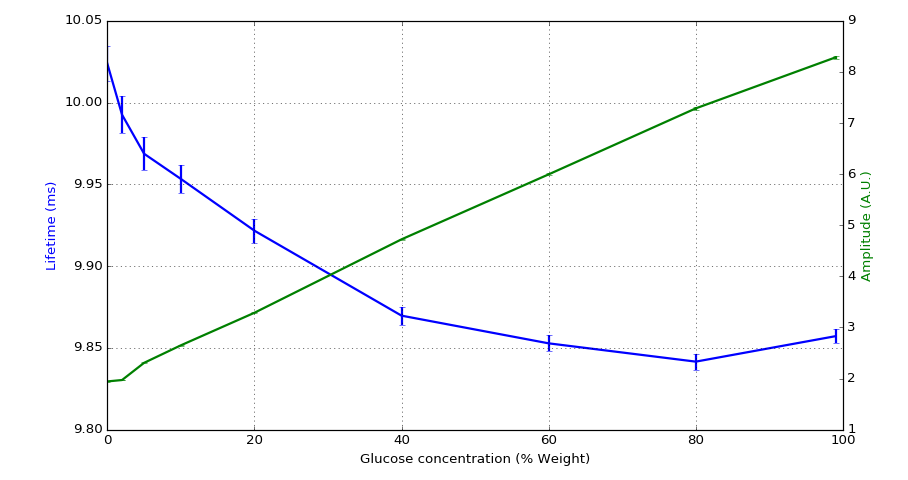

In [40]:
g = g.reset_index()

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.errorbar(g['concentration'], g['tau']['mean'], yerr=g['tau']['std'], color='b', lw='2')
ax2.errorbar(g['concentration'], g['A']['mean'], yerr=g['A']['std'], color='g', lw='2')

ax1.set_xlabel('Glucose concentration (% Weight)')
ax1.set_ylabel('Lifetime (ms)', color='b')
ax2.set_ylabel('Amplitude (A.U.)', color='g')

ax1.grid()
plt.tight_layout()
ax1.ticklabel_format(useOffset=False, axis='y')
ax2.ticklabel_format(useOffset=False, axis='y')

plt.tight_layout()
# plt.title(df['chip'][0])
plt.savefig('../Data/' + str(folder) + '/final' + '.png', dpi=600)